In [20]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from pathlib import Path
import skimage, skimage.filters
import scipy
import seaborn as sns
import sklearn, sklearn.svm
import pickle

d = Path("/tmp/fib_tmp")

In [2]:
def ewma_linear_filter(array, window):
    alpha = 2 / (window + 1)
    b = [alpha]
    a = [1, alpha - 1]
    zi = scipy.signal.lfiltic(b, a, array[0:1], [0])
    return scipy.signal.lfilter(b, a, array, zi=zi)[0]

In [3]:
t1 = nib.load("cropped_t1w.nii.gz").get_fdata().astype(np.float32)
t1_im = nib.load("cropped_t1w.nii.gz")
tissue_mask = nib.load("cropped_tissue_mask.nii.gz").get_fdata().astype(bool)

In [4]:
pv_csf_norm = np.nan_to_num(
    nib.load("lr-resampled-corrected-norm-hr_csf_vol_fraction.nii.gz")
    .get_fdata()
    .astype(np.float32),
    nan=0,
)
pv_gm_norm = np.nan_to_num(
    nib.load("lr-resampled-corrected-norm-hr_gm_vol_fraction.nii.gz")
    .get_fdata()
    .astype(np.float32),
    nan=0,
)
pv_wm_norm = np.nan_to_num(
    nib.load("lr-resampled-corrected-norm-hr_wm_vol_fraction.nii.gz")
    .get_fdata()
    .astype(np.float32),
    nan=0,
)

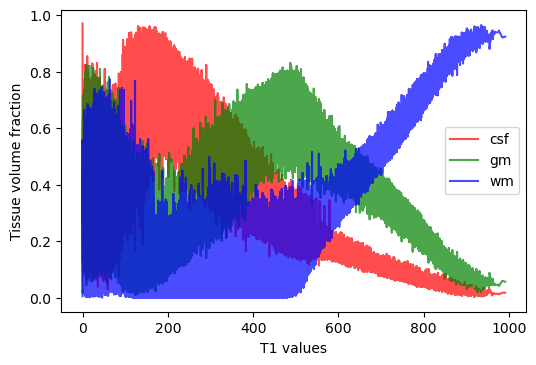

In [5]:
t1_v = t1[tissue_mask]
csf_v = pv_csf_norm[tissue_mask]
gm_v = pv_gm_norm[tissue_mask]
wm_v = pv_wm_norm[tissue_mask]

pv_sum_mask = (csf_v + gm_v + wm_v) > 0.99
t1_v = t1_v[pv_sum_mask]
csf_v = csf_v[pv_sum_mask]
gm_v = gm_v[pv_sum_mask]
wm_v = wm_v[pv_sum_mask]


t1_sort = np.argsort(t1_v)
p_kw = {"alpha": 0.7, "lw": 1.5}
window = 10
csf_ema = ewma_linear_filter(csf_v[t1_sort], window)
gm_ema = ewma_linear_filter(gm_v[t1_sort], window)
wm_ema = ewma_linear_filter(wm_v[t1_sort], window)
plt.figure(dpi=100)
plt.plot(t1_v[t1_sort], csf_ema, color="red", label="csf", **p_kw)
plt.plot(t1_v[t1_sort], gm_ema, color="green", label="gm", **p_kw)
plt.plot(t1_v[t1_sort], wm_ema, color="blue", label="wm", **p_kw)
plt.xlabel("T1 values")
plt.ylabel("Tissue volume fraction")
plt.legend()

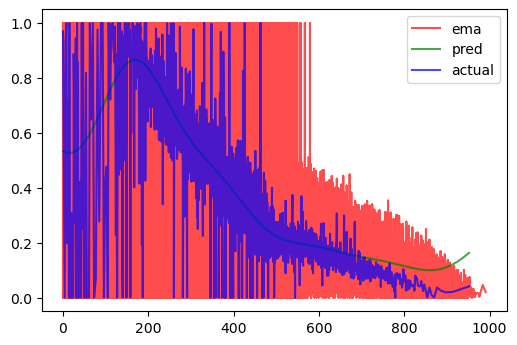

In [6]:
t1_v = t1[tissue_mask]
csf_v = pv_csf_norm[tissue_mask]
gm_v = pv_gm_norm[tissue_mask]
wm_v = pv_wm_norm[tissue_mask]

pv_sum_mask = (csf_v + gm_v + wm_v) > 0.99
t1_v = t1_v[pv_sum_mask]
csf_v = csf_v[pv_sum_mask]


t1_sort = np.argsort(t1_v)
p_kw = {"alpha": 0.7, "lw": 1.5}
window = 1
csf_ema = ewma_linear_filter(csf_v[t1_sort], window)

x = t1_v[t1_sort].reshape(-1, 1)
# y = csf_v[t1_sort]
y = csf_ema
model = sklearn.svm.SVR(kernel="rbf", max_iter=100000)
model.fit(x[::1000], y[::1000])

# ==========================================================
plt.figure(dpi=100)
plt.plot(t1_v[t1_sort], csf_ema, color="red", label="ema", **p_kw)

pred = model.predict(t1_v[t1_sort][::100].reshape(-1, 1))
plt.plot(t1_v[t1_sort][::100], pred, color="green", label="pred", **p_kw)

window_2 = 1
csf_ema_2 = ewma_linear_filter(csf_v[t1_sort], window_2)
plt.plot(t1_v[t1_sort][::500], csf_ema_2[::500], color="blue", label="actual", **p_kw)
plt.legend();

In [7]:
# Fit downsampled T1 vs. original partial volumes.

In [8]:
lr_t1 = nib.load("lr_downsample_t1.nii.gz").get_fdata().astype(np.float32)
lr_tissue_mask = nib.load("lr_downsample_tissue_mask.nii.gz").get_fdata().astype(bool)

In [9]:
lr_pv_csf = np.nan_to_num(
    nib.load("lr_csf_vol_fraction.nii.gz").get_fdata().astype(np.float32),
    nan=0,
)
lr_pv_gm = np.nan_to_num(
    nib.load("lr_gm_vol_fraction.nii.gz").get_fdata().astype(np.float32),
    nan=0,
)
lr_pv_wm = np.nan_to_num(
    nib.load("lr_wm_vol_fraction.nii.gz").get_fdata().astype(np.float32),
    nan=0,
)

<Figure size 432x288 with 0 Axes>

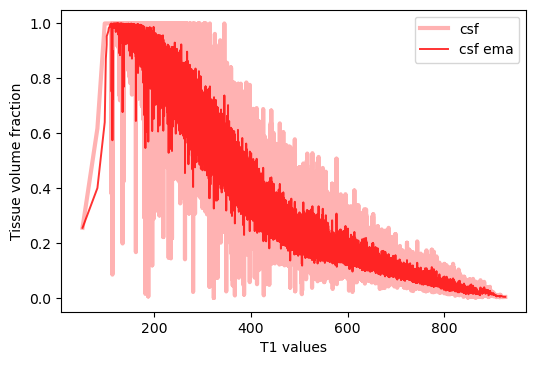

In [10]:
lr_t1_v = lr_t1[lr_tissue_mask]
lr_csf_v = lr_pv_csf[lr_tissue_mask]
lr_gm_v = lr_pv_gm[lr_tissue_mask]
lr_wm_v = lr_pv_wm[lr_tissue_mask]

lr_pv_sum_mask = (lr_csf_v + lr_gm_v + lr_wm_v) > 0.99
lr_t1_v = lr_t1_v[lr_pv_sum_mask]
lr_csf_v = lr_csf_v[lr_pv_sum_mask]
lr_gm_v = lr_gm_v[lr_pv_sum_mask]
lr_wm_v = lr_wm_v[lr_pv_sum_mask]


lr_t1_sort = np.argsort(lr_t1_v)
window = 4
lr_csf_ema = ewma_linear_filter(lr_csf_v[lr_t1_sort], window)
lr_gm_ema = ewma_linear_filter(lr_gm_v[lr_t1_sort], window)
lr_wm_ema = ewma_linear_filter(lr_wm_v[lr_t1_sort], window)

plt.clf()
plt.figure(dpi=100)
p_kw = {"alpha": 0.3, "lw": 3.0}
plt.plot(lr_t1_v[lr_t1_sort], lr_csf_v[lr_t1_sort], color="red", label="csf", **p_kw)
# plt.plot(lr_t1_v[lr_t1_sort], lr_gm_v[lr_t1_sort], color='green', label='gm', **p_kw)
# plt.plot(lr_t1_v[lr_t1_sort], lr_wm_v[lr_t1_sort], color='blue', label='wm', **p_kw)

p_kw = {"alpha": 0.8, "lw": 1.4}
plt.plot(lr_t1_v[lr_t1_sort], lr_csf_ema, color="red", label="csf ema", **p_kw)
# plt.plot(lr_t1_v[lr_t1_sort], lr_gm_ema, color='green', label='gm ema', **p_kw)
# plt.plot(lr_t1_v[lr_t1_sort], lr_wm_ema, color='blue', label='wm ema', **p_kw)
plt.xlabel("T1 values")
plt.ylabel("Tissue volume fraction")
plt.legend()

<Figure size 432x288 with 0 Axes>

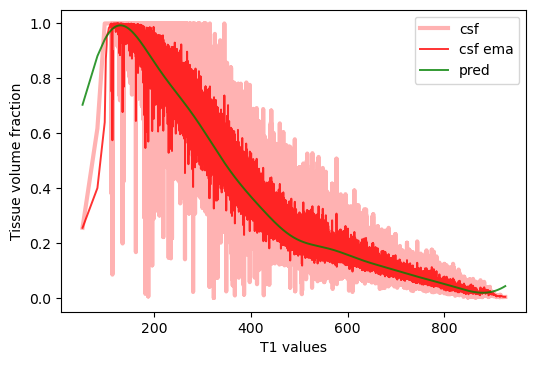

In [11]:
lr_t1_v = lr_t1[lr_tissue_mask]
lr_csf_v = lr_pv_csf[lr_tissue_mask]
lr_gm_v = lr_pv_gm[lr_tissue_mask]
lr_wm_v = lr_pv_wm[lr_tissue_mask]

lr_pv_sum_mask = (lr_csf_v + lr_gm_v + lr_wm_v) > 0.99
lr_t1_v = lr_t1_v[lr_pv_sum_mask]
lr_csf_v = lr_csf_v[lr_pv_sum_mask]
lr_gm_v = lr_gm_v[lr_pv_sum_mask]
lr_wm_v = lr_wm_v[lr_pv_sum_mask]


lr_t1_sort = np.argsort(lr_t1_v)
window = 4
lr_csf_ema = ewma_linear_filter(lr_csf_v[lr_t1_sort], window)
lr_gm_ema = ewma_linear_filter(lr_gm_v[lr_t1_sort], window)
lr_wm_ema = ewma_linear_filter(lr_wm_v[lr_t1_sort], window)

plt.clf()
plt.figure(dpi=100)
p_kw = {"alpha": 0.3, "lw": 3.0}
plt.plot(lr_t1_v[lr_t1_sort], lr_csf_v[lr_t1_sort], color="red", label="csf", **p_kw)
# plt.plot(lr_t1_v[lr_t1_sort], lr_gm_v[lr_t1_sort], color='green', label='gm', **p_kw)
# plt.plot(lr_t1_v[lr_t1_sort], lr_wm_v[lr_t1_sort], color='blue', label='wm', **p_kw)

p_kw = {"alpha": 0.8, "lw": 1.4}
plt.plot(lr_t1_v[lr_t1_sort], lr_csf_ema, color="red", label="csf ema", **p_kw)
# plt.plot(lr_t1_v[lr_t1_sort], lr_gm_ema, color='green', label='gm ema', **p_kw)
# plt.plot(lr_t1_v[lr_t1_sort], lr_wm_ema, color='blue', label='wm ema', **p_kw)
plt.xlabel("T1 values")
plt.ylabel("Tissue volume fraction")


x = lr_t1_v[lr_t1_sort].reshape(-1, 1)[::30]
# x = np.concatenate([x[:-20000:20], x[-20000:]], 0)
y = lr_csf_v[lr_t1_sort][::30]
# y = np.concatenate([y[:-20000:20], y[-20000:]])
model = sklearn.svm.SVR(kernel="rbf", max_iter=100000, epsilon=0.01)
model.fit(x, y)
pred = model.predict(lr_t1_v[lr_t1_sort].reshape(-1, 1))
plt.plot(lr_t1_v[lr_t1_sort], pred, color="green", label="pred", **p_kw)

plt.legend()

In [12]:
pred_csf_pv_vol = np.zeros_like(t1)
x_t1_full_res = t1[tissue_mask]
pred_csf_pv = model.predict(x_t1_full_res.reshape(-1, 1))
pred_csf_pv_vol[tissue_mask] = pred_csf_pv
nib.save(
    nib.Nifti1Image(pred_csf_pv_vol.astype(np.float32), t1_im.affine),
    "pred_csf_vol_fract.nii.gz",
)

In [13]:
cleaned_t1 = nib.load("denoised_cropped_t1w.nii.gz").get_fdata().astype(np.float32)

In [15]:
pred_csf_pv_vol = np.zeros_like(cleaned_t1)
x_t1_full_res = cleaned_t1[tissue_mask]
pred_csf_pv = model.predict(x_t1_full_res.reshape(-1, 1))
pred_csf_pv_vol[tissue_mask] = pred_csf_pv
nib.save(
    nib.Nifti1Image(pred_csf_pv_vol.astype(np.float32), t1_im.affine),
    "denoised_pred_csf_vol_fract.nii.gz",
)

In [26]:
with open("t1_to_csf-vol-fract_pred_SVR_model__sklearn-1_1_3.pickle", "wb") as f:
    pickle.dump(model, f)

Signature:
pickle.dump(
    obj,
    file,
    protocol=None,
    *,
    fix_imports=True,
    buffer_callback=None,
)
Docstring:
Write a pickled representation of obj to the open file object file.

This is equivalent to ``Pickler(file, protocol).dump(obj)``, but may
be more efficient.

The optional *protocol* argument tells the pickler to use the given
protocol; supported protocols are 0, 1, 2, 3, 4 and 5.  The default
protocol is 4. It was introduced in Python 3.4, and is incompatible
with previous versions.

Specifying a negative protocol version selects the highest protocol
version supported.  The higher the protocol used, the more recent the
version of Python needed to read the pickle produced.

The *file* argument must have a write() method that accepts a single
bytes argument.  It can thus be a file object opened for binary
writing, an io.BytesIO instance, or any other custom object that meets
this interface.

If *fix_imports* is True and protocol is less than 3, pickle will try